In [1]:
# Model calling and intial setup
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
import warnings
warnings.filterwarnings("ignore") 

load_dotenv()
# Load env
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
AZURE_BASE_URL = os.getenv("AZURE_BASE_URL")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_CHAT_DEPLIOYMENT_NAME = os.getenv("AZURE_CHAT_DEPLIOYMENT_NAME")

parser = StrOutputParser()

llm_gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash" , api_key= GOOGLE_API_KEY)

llm_openai = AzureChatOpenAI(
    model="gpt-4o-mini",                         
    deployment_name=AZURE_CHAT_DEPLIOYMENT_NAME ,  # deployment name in Azure
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_BASE_URL,
    api_version="2024-02-01"
    )
llm_openai.invoke("What are your creater, also what type of LLM are you").content
# llm_gemini.invoke("who is father of india").content

c:\Users\singh\Let's Gooooo\Langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


"I was developed by OpenAI, an artificial intelligence research organization. I am based on a large language model (LLM) architecture known as GPT (Generative Pre-trained Transformer). My primary function is to understand and generate human-like text based on the input I receive. If you have any specific questions or topics you'd like to discuss, feel free to ask!"

### First conditinal workflow

In [11]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict, Literal

class EqState(TypedDict):
    a : int
    b : int
    c : int
    
    eq : str
    dis : float
    root1 : float
    root2 : float
    
def show_eq(state : EqState)->EqState:
    eq = f"{state['a']}x^2 + {state['b']}x + {state['c']}"
    print(f"Eq : {eq}")
    
    state['eq'] = eq
    return state

def find_discriminate(state:EqState)->EqState:
    dis = (state['b'] **2)- (4 * state['a'] * state['c'])
    
    state['dis'] = dis
    return state

def real_roots(state : EqState)->EqState:
    root1 = (-state['b'] + state["dis"] **0.5) / (2*state['a'])
    root2 = (-state['b'] - state["dis"] **0.5) / (2*state['a'])
    
    state['root1'] = root1
    state['root2'] = root2
    return state

def repeated_roots(state : EqState)->EqState:
    root = (-state['b'])/(2*state['a'])
    
    state['root1'] = root
    state['root2'] = root
    return state

def no_real_roots(state : EqState)->EqState:
    state['root1'] = None
    state['root2'] = None
    return state

def check_condition(state:EqState)->Literal['Get_real_roots' , 'Get_repeated_roots' , 'Get_no_roots']:
    if state['dis'] > 0:
        return 'Get_real_roots'
    
    elif state['dis'] == 0:
        return 'Get_repeated_roots'
    else:
        return 'Get_no_roots'


graph = StateGraph(EqState)

# Add Node
graph.add_node("Show_Equation" , show_eq)
graph.add_node("Get_discriminant" , find_discriminate)
graph.add_node("Get_real_roots" , real_roots)
graph.add_node("Get_repeated_roots" , repeated_roots)
graph.add_node("Get_no_roots" , no_real_roots)

# Add Edges
graph.add_edge(START , "Show_Equation")
graph.add_edge("Show_Equation" , "Get_discriminant")
graph.add_conditional_edges("Get_discriminant" , check_condition)
graph.add_edge("Get_real_roots" , END)
graph.add_edge("Get_repeated_roots" , END)
graph.add_edge("Get_no_roots" , END)

first_workflow = graph.compile()

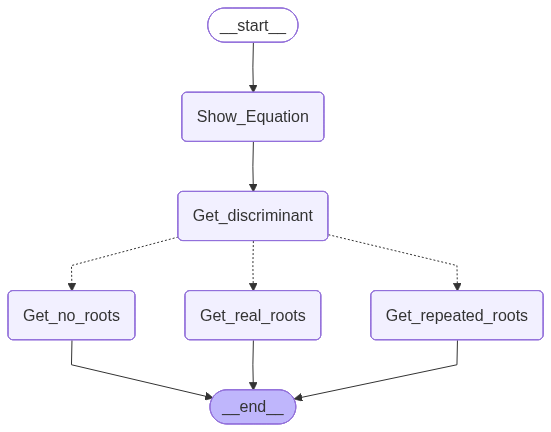

In [12]:
from IPython.display import Image
Image(first_workflow.get_graph().draw_mermaid_png())

In [15]:
first_workflow.invoke({"a" : -1 , "b":-6 , "c" : 8})

Eq : -1x^2 + -6x + 8


{'a': -1,
 'b': -6,
 'c': 8,
 'eq': '-1x^2 + -6x + 8',
 'dis': 68,
 'root1': -7.123105625617661,
 'root2': 1.1231056256176606}

### LLM Based Condtional Workflow

In [22]:
from pydantic import BaseModel , Field
from typing import Literal

class SentimentOutput(BaseModel):
    sentiment : Literal['Postive' , "Negative"] = Field(description="Sentiment of review based, classfiied as positive or negative")
    
class DiagonsisOutput(BaseModel):
    issue_type : str = Field(description="what is type of issue, Explained in breif")
    tone : str = Field(description="Tone of the review, calm , angry and so on etc..")
    urgency : int = Field(description="How Urgent is the urgency of the customer, from 1-10" , ge=0 , le=10)
    
llm_gemini_sentiment = llm_gemini.with_structured_output(SentimentOutput)
llm_gemini_diagonsis = llm_gemini.with_structured_output(DiagonsisOutput)

In [23]:
llm_gemini_diagonsis.invoke("The prodduct is worst that i have seen, and i want my refund right now")

DiagonsisOutput(issue_type='Refund', tone='angry', urgency=10)

In [ ]:
# Create a 